In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import CCA


In [3]:
def get_CCA(U, V, d):
    K, T, _ = U.shape
    U = U.swapaxes(1,2).reshape(-1, d) 
    V = V.swapaxes(1,2).reshape(-1, d)

    cca = CCA(n_components=d)
    cca.fit(U, V)
    U_c, V_c = cca.transform(U, V)
    corrs = [np.corrcoef(U_c[:, i], V_c[:, i])[0, 1] for i in range(d)]  
    return np.mean(corrs)

ds = np.arange(2,11)
ls_CCA_sca_ksca = []
ls_CCA_pca_ksca = []
ls_CCA_pca_sca = []
for d in ds:
    Y_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/Y_pca_{d}d.npy')
    Y_sca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth_linear/Y_{d}d.npy')
    Y_ksca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_gaussian.npy')
    ls_CCA_sca_ksca.append(get_CCA(Y_sca, Y_ksca, d)) 
    ls_CCA_pca_ksca.append(get_CCA(Y_pca, Y_ksca, d)) 
    ls_CCA_pca_sca.append(get_CCA(Y_pca, Y_sca, d)) 


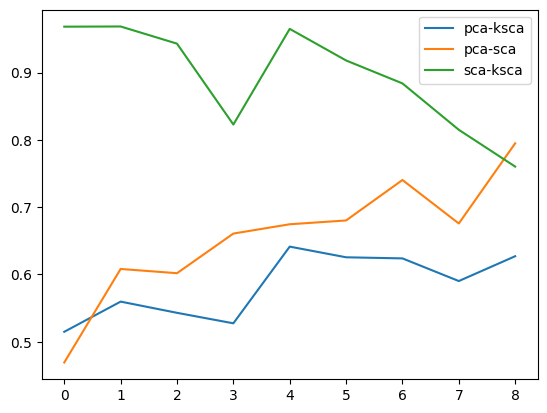

In [5]:
plt.plot(ls_CCA_pca_ksca, label='pca-ksca')
plt.plot(ls_CCA_pca_sca, label='pca-sca')
plt.plot(ls_CCA_sca_ksca, label='sca-ksca')
plt.legend()